# Qlib Explorer

## Installation

For normal x86 intel chip or amd chip, just create a conda virtual environment in python 3.8, then use `pip install` to make a qlib environment. code as follows:

```shell
conda create -n qlib python=3.8
conda activate qlib
pip install pyqlib
```

But on Mac M1 arm, things are slightly different, but to start with, create a conda environment.

```shell
conda create -n qlib python=3.8
```

Then, clone the qlib project to a proper directory, like `Desktop`

```shell
git clone https://github.com/microsoft/qlib
```

Then, `cd` to the directory and install the dependency using conda first

```shell
conda install lightbgm ecos pytables cvxpy mlflow fire ruamel
```

These dependencies are neccessary to install by conda because the are not pure python package, without conda, the installation might not be successful. After installing these, we can simple use the command below to install the qlib library to Mac M1 locally.

```shell
export HDF5_DIR=/path/to/somewhere/you/want/to/store/hdf5file
pip install .
```

Wait for a second, the installation will be successful. And the following cell can be run.

In [ ]:
import qlib

qlib.__version__

## Data Transformation

### Daily Data

The Qlib provide a better storage plan for most of quanters, we can view this as below:

![qlib-storage-structure](../images/qlib_storage_structure.png)

In features directory, keeps the features of our dataset, each stock for a directory, and each feature a bin file in the directory. Show as follows:

![qlib-storage-features](./images/qlib_storage_features.png)

Anyway, the three core file in these directories are `day.txt`, `all.txt`, and the `bin files`. The `day.txt` simply stored the all trading day calender amoung all instruments, which is the union set of the all instruments' trading days. The `all.txt` records the entry date and exit date for every instrument in a line. The `bin files` are slightly special, the value of them are a column for one sepcified instrument, but the **first value is the index of the feature start date in `day.txt`**, and the file is stored in numpy generic `bin` format wihout any extra information.

To generate these files, you can simple realize that by numpy or pandas. For `day.txt`, simply construct the union set of your total data, and store them into a list, use `np.savetxt` is quite enough, or you can construct a Series (or DataFrame), using `data.to_csv('day.txt', headers=False, index=False)` is also a great way to accomplish that. For `all.txt`, get the min date and max date for each instrument, construct a list or DataFrame, use `np.savetxt` or `data.to_csv` like above works fine, further more, to make this faster, we recommend using `pandas.core.DataFrame.groupby`. For `bin files`, we need to get each instrument, and get the index of first date, save the numpy format data using `data[feature].value.tofile`. But before that, we must apply `np.hstack([date_index, data[feature].value])` first. However, in updating process, `hstack` is not neccessary.

Qlib provide a `script/dump_bin` script to simplify our workflow of dumping data into bin, however, that is for `csv` file only, if your files are `feathe` or `parquet` format, that can not help. So we provide a `SingleFileDumper` in [library](../library/dumper.py). You can try that.

In [ ]:
class Dumper:
    ...
class IndexCompDumper(Dumper):
    ...
def format_code():
    ...

In [ ]:
%run ../mylib/utils.py
%run ../mylib/dumper.py

In [ ]:
import pandas as pd

data = pd.read_parquet('../data/kline_daily/market_daily.parquet')
new_data = pd.read_parquet('../data/kline_daily/kline_daily_20220805_20220819.parquet')
turnover = pd.read_parquet('../data/derivative_indicators/turnover.parquet')
turnover = turnover['today']
turnover.name = 'turnover'
index_comp = pd.read_parquet('../data/index/index_weights.parquet')
index_market = pd.read_parquet('../data/index/index_market_daily.parquet')

In [ ]:
data.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(data.index.get_level_values(0)),
    data.index.get_level_values(1).str.slice(0, 6).map(format_code),
])
new_data.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(new_data.index.get_level_values(0)),
    new_data.index.get_level_values(1).str.slice(0, 6).map(format_code),
])
turnover.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(turnover.index.get_level_values(0)),
    turnover.index.get_level_values(1).str.slice(0, 6).map(format_code),
])
index_market.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(index_market.index.get_level_values(0)),
    index_market.index.get_level_values(1).map(format_code),
])
index_comp.index = pd.MultiIndex.from_arrays([
    pd.to_datetime(index_comp.index.get_level_values(0)),
    index_comp.index.get_level_values(1).map(format_code),
    index_comp.index.get_level_values(2).str.slice(0, 6).map(format_code),
])

In [ ]:
Dumper(data, uri='../data/qlib_day', mode='w').dump()
Dumper(new_data, uri='../data/qlib_day', mode='a').dump()
Dumper(turnover, uri='../data/qlib_day/', mode='f').dump()
IndexCompDumper(index_comp, index_col=1, uri='../data/qlib_day').dump()
Dumper(index_market, uri='../data/qlib_day', mode='a').dump()

### PIT Data

PIT data can be easily processed and stored in a continuous time series based file or database. However, this way of storing is not only redudent but also time consuming. Qlib provide us a clever way to store PIT data.

PIT data store in the same directory with daily kline data, but has a independent directory called financial. Each instrument has a sub-directory like the feature sub-directory. But what is different is that each feature not only depends on one binary file, but also a index binary file. Let's start with the index file.

The index file should ends with the suffix '.index', and all features in `financial` data should be followed by `_q` or `_a` ending, `_q` means it is quartly data, and `_a` means it is annually data. To start with, the first element in index file is `start_year`, this is a unsigned integer, marked as `'I'`, and this is used as the first report period year amoung the data. The, the binary index file is followed with **byte index**, this index is the actual file cursor offset index indicating the position of `.data` file.

Then we turn to the `.data` file, this is where the data actually stored. the data is stored in a 4 column array (however it is not store in numpy array binary format, the original data is generated by `struct` package). The first column is the annote date, indicating the actual date of publishing the data. The second columns is report period, meaning to which report period the data belongs. The third column is real value of the data. The fourth column is the byte index where current data appears again, it points to a infinitely large position if it is the latest data for that period. This structure is some what like a chained table, when given a date, we can easily access the latest published data on that date, and at the same time, we can easily get the latest data "in the future" (quoted because the future is relative to that given date).

![pit-data](./images/pit-data.png)

Moreover, when accessing the pit data, we can use the indentifier and operater like `"P($$some_ind_q)"` before the actual feature name.

In [ ]:
class PDumper:
    ...

In [ ]:
balance_sheet = pd.read_parquet('../data/financial/balance.parquet')
balance_sheet.SECUCODE = balance_sheet.SECUCODE.map(format_code)

In [ ]:
%run ../mylib/dumper.py

In [ ]:
PDumper(
    balance_sheet,
    inst_col = 'SECUCODE',
    ann_col = 'NOTICE_DATE',
    period_col = 'REPORT_DATE',
    uri = '../data/qlib_day/'
).dump()

## Data Access

Now we have successfully converted daily trading data into qlib format, we can use the qlib api to fetch useful data into memory.

There is a `D` interface provided in `qlib.data`, with the `feature` method, we can get access to specific feature for instrument during given time.

Mind that this is only a simplified interface, in the following part we will introduce the interface for real workflow

In [ ]:
import plotly.graph_objects as go
from qlib.data import D
import qlib

In [ ]:
# qlib.init()
qlib.init(provider_uri='../data/qlib_day/')

In [ ]:
D.features(['sh.600009'], ['P($$accounts_payable_q)'], start_time="2020-01-01", end_time="2021-01-01", freq="day").head()

In [ ]:
D.features(instruments=['sh.600519'], start_time='2021-01-01', end_time='20220819', fields=['$open', '$high', '$low', '$close']).head()

## Data Loader

### QlibDataLoader

Data Loader is a builtin qlib data reader, we can use this class to load any cross sectional and time series data. We can initialize it with a `config` parameter, and provide the `expression variable` and `rename variable` in two list.

In [ ]:
from qlib.data.dataset.loader import QlibDataLoader

# like sql `as` expression, the latter list indicates the names of the column
qdl = QlibDataLoader(config=(['$close', '$high'], ['close', 'high']))
qdl.load(instruments=['600519.xshg'], start_time='2022-08-01', end_time='20220819')

We can also use the qlib expression engine to load some calculated features into the memory

In [ ]:
insts = ['600000.XSHG', '600004.XSHG', '600009.XSHG']
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']
ma_names = ['EMA10', 'EMA30']
qdl_ma = QlibDataLoader(config=(close_ma, ma_names))
qdl_ma.load(instruments=insts, start_time='20210101', end_time='20210110')

Moreover, you can find other expression operator in `/qlib/data/ops.py`

Sometimes, we need to classify the calculated data, the most frequently used class name is `feature` and `label`, we can change the `list format config` to `dict format config`.

In [ ]:
insts = ['600000.XSHG', '600004.XSHG', '600009.XSHG']
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']
ma_names = ['EMA10', 'EMA30']
ret = ['Ref($close, -2) / Ref($close, -1) - 1',]
ret_name = ['forward',]
qdl_ma_gp = QlibDataLoader(config={'feature': (close_ma, ma_names), 'label': (ret, ret_name)})
qdl_ma_gp.load(instruments=insts, start_time='20210101', end_time='20210110')

Using parameter `filter_pipe` can also help us filter stocks which only satisfy our preset conditions.

In [ ]:
from qlib.data.filter import ExpressionDFilter

insts = 'all'
close_ma = ['EMA($close, 10)', 'EMA($close, 30)']
ma_names = ['EMA10', 'EMA30']

filter_rule = ExpressionDFilter(rule_expression='EMA($close, 10) > EMA($close, 30)')

qdl_fil = QlibDataLoader(config=(close_ma, ma_names), filter_pipe=[filter_rule,])
qdl_fil.load(instruments=insts, start_time='20210104', end_time='20210104')

### StaticDataLoader

Also, qlib provide us a `StaticDataLoader` for direct access to outer data file, it reads pickle file by default, but, with a dictionary format parameter `config`, csv and h5df format are also supported.

And not only the static file can be read by `StaticDataLoader`, the in memory dataframe can be read by `StaticDataloader`

In [ ]:
qdl = QlibDataLoader(config=(['$open', '$high', '$low', '$close'], ['open', 'high', 'low', 'close']))
df = qdl.load(instruments=['600000.XSHG', '600004.XSHG', '600009.XSHG'], start_time='20210101', end_time='20211231')
df.to_pickle('../data/other/sample.pkl')

In [ ]:
from qlib.data.dataset.loader import StaticDataLoader

sdl_pkl = StaticDataLoader(config={'feature': '../data/other/sample.pkl'})
sdl_pkl.load(instruments=['600009.XSHG'], start_time='20210101', end_time='20210131')

In [ ]:
data = sdl_pkl.load(instruments=['600009.XSHG'], start_time='20210101', end_time='20210131')
sdl_df = StaticDataLoader(config=data)
sdl_df.load()

## Data Handler

Before model training, we must preprocess some data like missing value, or simply standarize our dataset. DataHandler is designed for this.

DataHandler takes three key parameters in the process of handling data:

1. infer_processors: **learn parameters during fitting time, and process data during non-fitting time**
2. learn_processors: **process data without learning**
3. shared_processors: **shared processors**

Because there is learning process in `infer_processors`, they where provide `fit` method in their class definition.

DataHandler will keep raw data and processed data during processing, when user fetches data, it will return different types of data according to the data key.

> *In my point of view, the `learn_processors` are more like a time-series based data processors, and the `infer_processors` are cross-section based data processors*

1. `data_key = DataHandlerLP.DK_I`, return infer df
2. `data_key = DataHandlerLP.DK_L`, return learn df
3. `data_key = DataHandlerLP.DK_R`, return raw df

There is another parameter called `process_type`, which decide the sequence of processing data

1. `process_type = DataHandlerLP.PTYPE_I`, process of independent
2. `process_type = DataHandlerLP.PTYPE_A`, process of append

![process-type](./images/process-type.jpg)

In [ ]:
from qlib.data.dataset.processor import CSZScoreNorm, DropnaProcessor, ZScoreNorm
from qlib.data.dataset.handler import DataHandlerLP

shared_processors = [DropnaProcessor()]
learn_processors = [CSZScoreNorm()]
infer_processors = [ZScoreNorm(fit_start_time='20210101', fit_end_time='20210110')]

dh_pr_test = DataHandlerLP(
    instruments = ['600000.XSHG', '600004.XSHG', '600009.XSHG'],
    start_time = '20210101',
    end_time = '20210120',
    process_type = DataHandlerLP.PTYPE_I,
    learn_processors = learn_processors,
    shared_processors = shared_processors,
    infer_processors = infer_processors,
    data_loader = qdl,
)

Okay, let's fetch the results

In [ ]:
raw_df = dh_pr_test.fetch(data_key=DataHandlerLP.DK_R)
infer_df = dh_pr_test.fetch(data_key=DataHandlerLP.DK_I)
learn_df = dh_pr_test.fetch(data_key=DataHandlerLP.DK_L)

infer_df.isna().sum(), learn_df.isna().sum()

In [ ]:
learn_df.head()

In [ ]:
infer_df.head()

## DataSet

Now, we come to the last step before training, dataset spliting.

Dataset class definition is directly stored in `qlib.data.dataset`. Now we can have a overview of the `qlib.data.dataset` package. The workflow is to initialize a `DataLoader` for `DataHandler`, and initialize the `DataHandler` for a final `DataSetH`, where 'H' means `Handler`, indicating that the `DataSet` is constructed from a `DataHandler`.

In [ ]:
from qlib.data.dataset import DatasetH

ds = DatasetH(handler=dh_pr_test, segments={"train": ("20210101", "20210105"), "test": ("20210106", "20210110")})

To fetch the splited data, use `ds.prepare`, the parameter is the segments name

In [ ]:
ds.prepare('train').head()

In [ ]:
ds.prepare('test').head()

As a matter of fact, some model takes time series data as input, or they are trained in a rolling window. Qlib provide us a class called `TSDataH` which helps us generate time-series dataset. just follow the next cell, you will create a ten-day rolling window dataset. And with the day rolling on, you can get latest data in `data[date]` way. Then you can feed them into the model, then train it rollingly.

**NOTE: althogh the `TSDataSampler` can access data through `[datetime, asset]`, but unlike the pandas index, `TSDataSampler` won't check whether the asset exist. Actually, it use `bisect.bisect_right` to judge the position of asset. So nonexist asset might be accepted and the return won't be the asset information.**

In [ ]:
from qlib.data.dataset import TSDatasetH
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import CSZScoreNorm

dl = QlibDataLoader(
    config = [
        ("$open", "$high", "$low", "$close"),
        ("open", "high", "low", "close"),
    ]
)
dh = DataHandlerLP(
    instruments = "000016.XSHG",
    start_time = "20200101",
    end_time = "20220801",
    process_type = "independent",
    # infer_processors = [CSZScoreNorm()],
    data_loader = dl
)
ds = TSDatasetH(
    step_len = 10,
    segments = {
        "train": ("20200101", "20220101"),
        "valid": ("20220104", "20220601"),
        "test": ("20220602", "20220801"),
    },
    handler = dh,
)
train_sampler = ds.prepare('train')

The `TSDatasetH` returns a `TSDataSampler` as output. This is a class providing rolling window data. It can be selected in normal pandas way like `[datetime, asset]`, and it can also be selected by a single integer.

When you sample in a pandas way, you will get a `np.ndarray`, and you may encounter a lot of `nan`s in the results in first few samples. That's because the number of data doesn't fit the rolling window, so qlib can fulfill them with `nan` automatically. however, when encountering `nan` data in the middle part, the `fillna_type` can really work.

In [ ]:
import pandas as pd

dl.load(instruments=['600000.XSHG'], start_time='20200917', end_time='20201001').droplevel(1)

In [ ]:
train_sampler['20201001', "600000.XSHG"]

Like said before, the other way of selecting data in sampler is using integer. The logic of using integer to slice data is:

1. convert the integer to a tuple, assuming this integer as the index of sampler data index, which you can access by `train_sampler.data_index`;
2. from the tuple before, the first value is the date index, and the second value is the instrument index. Then we select the latest `step_len` days within the same asset, return the data.

This method is not that explicit, so maybe the pandas style slicing is more useful.

In [ ]:
# train_sampler.idx_df store the index mapping in a dataframe format
n = train_sampler.data_index.get_indexer([('20200930', '600000.XSHG')])
train_sampler[n]

Last but not least, here are some useful attributes that may help you find the logic of slicing:

1. `train_sampler.data_index`, a data index which is taken from the original dataset
2. `train_sampler.idx_df`, a index mapping for `train_sampler.data_index`, the value of the dataframe is the position index from `train_sampler.data_index`
3. `train_sampler.data_arr`, original dataset in array format
4. `train_sampler.idx_map`, the ndarray form index storing the numerical index for `train_sampler.data_index`

## Model Training

Now, we can get processed dataset with features and label. The next step is to train the dataset using different models. Qlib has a lot of builtin models, the same, they are located in `qlib.contrib.model`.

In [ ]:
from qlib.contrib.data.handler import Alpha158
from qlib.data.dataset import TSDatasetH
from qlib.contrib.model.pytorch_alstm_ts import ALSTM

train_period = ("2021-01-01", "2021-01-10")
valid_period = ("2021-01-11", "2021-01-15")
test_period = ("2021-01-16", "2021-01-20")

dh = Alpha158(
    instruments = ['600000.XSHG', '600004.XSHG', '600009.XSHG'],
    start_time = train_period[0],
    end_time = test_period[1],
    infer_processors = {}
)
ds = TSDatasetH(
    handler = dh,
    step_len = 40,
    segments = {
        "train": train_period,
        "valid": valid_period,
        "test": test_period,
    },
)
model = ALSTM(
    d_feat = 158,
    metric = "mse",
    run_type = "GRU",
    batch_size = 800,
    early_stop = 10,
)
model.fit(dataset = ds, save_path = None)
model.predict(dataset=ds, segement='test')

## Configuration

Actually, Qlib provide users a more convenient way to initialize a `QlibDataLoader`, `DataHandler` , `Dataset` or even a `Model`. The interface function is `init_instance_by_config`.

In [ ]:
from qlib.utils import init_instance_by_config

qdl_config = {
    "class": "QlibDataLoader",
    "module_path": "qlib.data.dataset.loader",
    "kwargs": {
        "config": {
            "feature": (['EMA($close, 10)', 'EMA($close, 30)'], ['EMA10', 'EMA30']),
            "label": (['Ref($close, -2) / Ref($close, -1) - 1'], ['Forward',]),
        },
        "freq": "day",
    }
}

qdl = init_instance_by_config(qdl_config)
insts = ['600000.XSHG', '600004.XSHG', '600009.XSHG']
qdl.load(instruments=insts, start_time='20210101', end_time='20210131').head()

And it is also availble for us to omit the `module_path` key in `qdl_config`, but it should be implemented in `class` key like:

```python
qdl_config = {
    "class": "qlib.data.dataset.loader.QlibDataLoader",
    "kwargs": {
        ...
    }
}
```

Since the `DataHandler` can also be initialized by `init_instance_by_config`, we can actually save some factor definition by using the config dictionary. But to start with, we inherit a `DataHandlerLP`. So we can fetch handled data simply by `fetch` function and construct a `Dataset` easily.

In [ ]:
class MACDRSIFeature(DataHandlerLP):
    def __init__(
        self,
        instruments = None,
        start_time = None,
        end_time = None,
        freq = "day",
        infer_processors = [],
        learn_processors = [],
        fit_start_time = None,
        fit_end_time = None,
        process_type=DataHandlerLP.PTYPE_A,
        **kwargs,
    ):
        data_loader = {
            "class": "QlibDataLoader",
            "kwargs": {
                "config": {
                    "feature": self.get_feature_config(),
                    "label": kwargs.get("label", self.get_label_config()),
                },
                "freq": freq,
            }
        }
        super().__init__(
            instruments = instruments,
            start_time = start_time,
            end_time = end_time,
            data_loader = data_loader,
            infer_processors = infer_processors,
            learn_processors = learn_processors,
            process_type = process_type,
        )
    
    def get_feature_config(self):
        macd = '(EMA($close, 12) - EMA($close, 26)) / $close - EMA((EMA($close, 12) - EMA($close, 26)) / $close, 9) / $close'
        rsi = ('100 - 100 / (1 + (Sum(Greater($close - Ref($close, 1), 0), 14) / Count(($close - Ref($close, 1)) > 0, 14)) /'
            '(Sum(Abs(Greater(Ref($close, 1) - $close, 0)), 14) / Count(($close - Ref($close, 1)) < 0, 14)))')
        return [macd, rsi], ['MACD', 'RSI']
    def get_label_config(self):
        return (["Ref($close, -2) / Ref($close, -1) - 1", ], ["Forward", ])
    
feature = MACDRSIFeature(instruments=['600000.XSHG', '600004.XSHG', '600009.XSHG'], start_time='20210101', end_time='2021-01-31')
feature.fetch().head()

Actually, inheriting `DataHandlerLP` doesn't come from nowhere, the builtin `Alpha158` and `Alpha360` also takes the same way. And moreover, models, preset factors almost all located in `qlib.contrib`, where you can check out later.

Here we provide a snippet of `Alpha360` definition in qlib

```python
class Alpha360(DataHandlerLP):
    def __init__(
        self,
        instruments="csi500",
        start_time=None,
        end_time=None,
        freq="day",
        infer_processors=_DEFAULT_INFER_PROCESSORS,
        learn_processors=_DEFAULT_LEARN_PROCESSORS,
        fit_start_time=None,
        fit_end_time=None,
        filter_pipe=None,
        inst_processor=None,
        **kwargs,
    ):
    ...
```

By this kind of configurations, we can easily construct dataset and model, and this can be called a workflow.

In [ ]:
ds_config = {
    "class": "TSDatasetH",
    "module_path": "qlib.data.dataset",
    "kwargs": {
        "handler": {
            "class": "Alpha158",
            "module_path": "qlib.contrib.data.handler",
            "kwargs": {
                "start_time": "2015-01-01",
                "end_time": "2022-03-01",
                "fit_start_time": "2015-01-01",
                "fit_end_time": "2019-12-31",
                "instruments": ['600000.XSHG', '600004.XSHG', '600009.XSHG'],
                "infer_processors": [
                    {
                        "class": "RobustZScoreNorm",
                        "kwargs": {
                            "fields_group": "feature",
                            "clip_outlier": True,
                        },
                    },
                    {
                        "class": "Fillna",
                        "kwargs": {
                            "fields_group": "feature",
                        },
                    },
                ],
                "learn_processors": [
                    {
                        "class": "DropnaLabel",
                    },
                    {
                        "class": "CSRankNorm",
                        "kwargs": {
                            "fields_group": "label"
                        }
                    },
                ],
                "label": ["Ref($close, -2) / Ref($close, -1) - 1"],
            }
        },
        "segments": {
            "train": ["2015-01-01", "2019-12-31"],
            "valid": ["2020-01-01", "2020-12-31"],
            "test": ["2021-01-01", "2022-03-01"],
        },
        "step_len": 40,
    }
}
model_config = {
    "class": "ALSTM",
    "module_path": "qlib.contrib.model.pytorch_alstm_ts",
    "kwargs": {
        "d_feat": 158,
        "hidden_size": 64,
        "num_layers": 2,
        "dropout": 0.0,
        "n_epochs": 200,
        "lr": 1e-3,
        "early_stop": 10,
        "batch_size": 800,
        "metric": "loss",
        "loss": "mse",
        "n_jobs": 20,
        "GPU": 0,
        "run_type": "GRU",
    }
}

ds = init_instance_by_config(ds_config)
model = init_instance_by_config(model_config)
model.fit(dataset=ds)

Also, using the `yaml` package to load yaml format configuration and run is availble in qlib.

## Recorder

Recorder serves as a machine learning process keeper. We can save some middle results or the uncompleted models to disk. When we set `resume` parameter to `True`, the training process will start where the last time ends.

There three typical recorder in qlib:

1. SignalRecord, for test data, generate predict value with trained model
2. SigAnaRecord, analyze generated predict value, calculating IC, IR etc.
3. PortAnaRecord, backtest predict factor value, to see the backtest performance

Normally for a machine learning training task, we need to perform a series of experiments and find the best result. Qlib provide us a `Recorder` class that can record every experiments we have already performed. And for each experiments, we can set different recorder to record the different parameter or result.

To begin with, initialize the qlib and import the `R` instance from `qlib.workflow`.

In [ ]:
import qlib
from qlib.workflow import R

qlib.init(provider_uri='../data/qlib_day/')

`R` instance provide us a easy to use interface that can record everthing into our disk. To begin with, we need to enter the environment that the recorder created. Use `R.start` as a context manager, so in the environment, R can log or save things.

In [ ]:
with R.start(experiment_name='4', uri='./experiments/'):
    # purely text in `<uri>/<experiment_id>/<recorder_id>/params` directory
    R.log_params(some_dummy_params = {
        "foo": 1,
        "bar": 2,
        "somestr": "foobar",
        "floatnum": 3.1415926,
        "somebool": True
    })
    # in `<uri>/<experiment_id>/<recorder_id>/artifacts/[<artifact_path>]` directory
    R.save_objects(**{
        "test_save": "someobjects"
    }, artifact_path='test_artifact')
    for step in range(10):
        R.log_metrics(step=step, **{
            "test_metric_1": 0.618,
            "test_metric_2": 2.71828,
        })
    rec = R.get_recorder()

After saving, we need to load objects or things for later analysis or caculation. You can also get the current record from R and read.

In [ ]:
# remind we have set the parameter `artifact_path` in save_object 
# so in loading process we need to add before the actual file
rec.load_object('test_artifact/test_save')
rec.list_params()
rec.list_metrics()

## Strategy

User can define their own strategy class in qlib with inheriting `BaseStrategy`, the core logic should be in `generate_trade_decision` fucntion. This is just like `handle_data` function in zipline framework.

There are 3 key parameters in class `BaseStrategy` initialization:

1. level_infra: level infrastructure, some common components, like trading calendar
2. common_infra: common infrastructure, some common components, like trade_positions, exchange market
3. trade_exchange: when set, use this to represent exchange_market, else turn to find exchange parameter in `common_infra`

The core process of backtest strategy in qlib starts with `get_signal`, and then, your strategy class will generate trade decision by `generate_trade_decision` function, the decision results will by passed to Executor, which is a class connecting strategy and the exchange market. Once the decision is passed, the order will by delivered from executor to exchange, it will generate a `execu_result` from exchange market. Moreover, the result will be returned to the strategy itself.

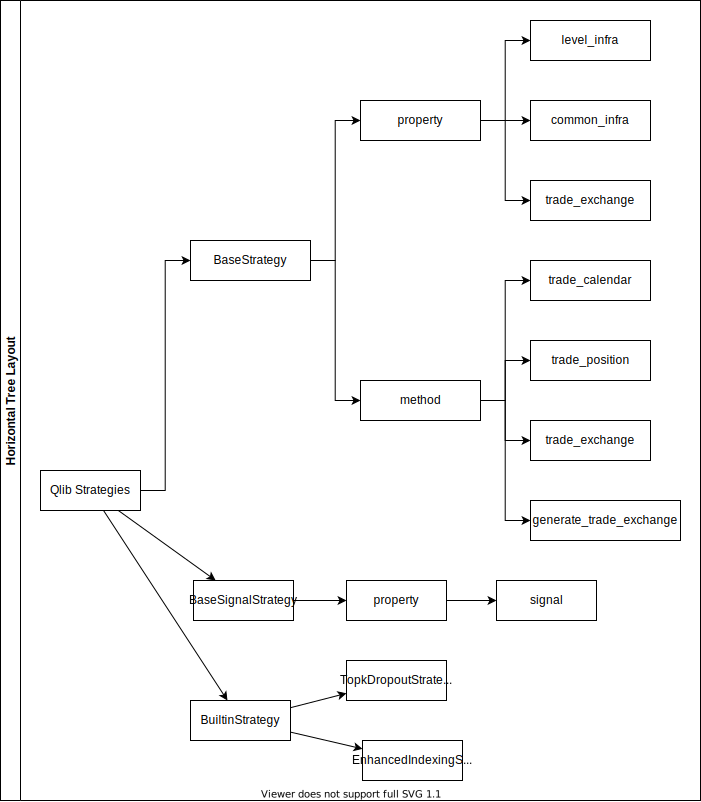

In [6]:
from IPython.display import display_svg

display_svg(open('../images/qlib_strategies.svg', 'r'), raw=True)

### Index Enhancing Strategy

Currently, the Index Enhancing Strategy isn't decoupled, it depends on the `qlib.data.D`, but just for query index weight usage. So, if we want to use the strategy now, we must construct our own database or use the database with qlib.

The execution flow is shown as follows. To begin with, the index enhancing strategy is a weight based strategy, so it is the same with other WeightStrategy, the core interface is `generate_target_weight_position`, which returns the order list. It uses the `qlib.contrib.strategy.optimizer.enhanced_indexing.EnhancedIndexingOptimizer` as the internal optimizer. For each day bar, the steps are shown inthe graph.

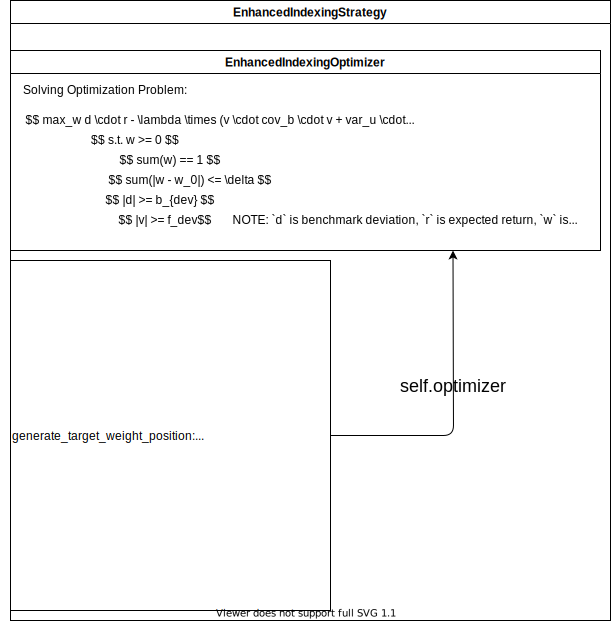

In [4]:
from IPython.display import display_svg
display_svg(open('../images/enhanced_indexing.svg', 'r'), raw=True)